In [1]:
# def evaluate(battery_swap_schedule):
#     total_travel_time = 0
#     total_waiting_time = 0
#     battery_urgency_score = 0
#     active_fleet_batery_score = 0
#     total_battery_cycle = 0
#     for ev_id, sched in battery_swap_schedule.items():
#         if sched and sched.get("assigned"):
#             total_travel_time += sched["travel_time"]
#             total_waiting_time += sched["waiting_time"]
#             battery_urgency_score += ((100 - sched["exchanged_battery"]) ** 2)
#             active_fleet_batery_score += (sched["received_battery"] ** 2)
#             total_battery_cycle += sched["received_battery_cycle"]
#         elif sched:
#             active_fleet_batery_score += sched["battery_now"]
#     if total_travel_time or total_waiting_time:
#         total_score = (battery_urgency_score + active_fleet_batery_score) / ((total_travel_time + (10 * total_waiting_time))/60 + total_battery_cycle/8)
#     else:
#         total_score = battery_urgency_score + active_fleet_batery_score

#     return total_score

def evaluate(battery_swap_schedule):
    total_score = 0
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            beg = (sched["received_battery"] * (1 - 0.00025 * sched["received_battery_cycle"])) - (sched["exchanged_battery"] * (1 - 0.00025 * sched["exchanged_battery_cycle"])) 
            # print("Received battery", sched["received_battery"])
            # print("Received battery with cycle", sched["received_battery"] * (1 - 0.00025 * sched["received_battery_cycle"]))
            # print("Exchanged battery", sched["exchanged_battery"])
            # print("Exchanged battery with cycle", sched["exchanged_battery"] * (1 - 0.00025 * sched["exchanged_battery_cycle"]))
            # print("BEG", (0.75 * beg))
            # print("waiting time", (0.25 * sched["waiting_time"]))
            # print("time", sched["waiting_time"])
            # print("score", ((0.75 * beg) - (0.25 * sched["waiting_time"])))
            total_score = total_score + ((0.75 * beg) - (0.25 * sched["waiting_time"]))

    return total_score

In [2]:
import copy

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []

    # 1. Masukkan jadwal tetap (dari ev['swap_schedule']) dulu ke slot_timeline
    # Kumpulkan semua jadwal tetap dari ev['swap_schedule']
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    # Urutkan setiap antrian berdasarkan arrival_time
    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    # 2. Kumpulkan EV dari solusi yang assigned, tapi hanya yang tidak punya jadwal tetap
    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    # 3. Urutkan berdasarkan arrival_time (yang datang duluan diproses lebih dulu)
    swaps.sort()

    # 4. Proses masing-masing EV, hitung ulang waiting_time dan received_battery
    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        # Update ke dalam solution
        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        # Tambahkan ke slot_timeline untuk update antrian selanjutnya
        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution

In [3]:
import random

def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    # Inisialisasi semua EV yang punya schedule tetap
    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    # Ambil EV yang layak dijadwalkan
    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue

        if data['battery_now'] <= 40:
            energy_to_nearest = min(data['energy_distance'])
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - energy_to_nearest < threshold:
                candidates.append(i)
        else:
            solution[i] = {
                'assigned': False,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'exchanged_battery_cycle': None,
                'received_battery_cycle': None,
                'status': None,
                'scheduled_time': None,
            }
            continue

    # Acak urutan EV
    random.shuffle(candidates)

    # Jadwalkan secara acak ke slot kosong
    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'exchanged_battery_cycle': None,
                'received_battery_cycle': None,
                'status': None,
                'scheduled_time': None,
            }
            continue

        # Pilih slot acak dari opsi valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        degradation_factor = 1 + (0.00025 * data['battery_cycle'])

        exchanged_battery = data['battery_now'] - energy_dist * degradation_factor

        solution[i] = {
            'assigned': True,
            'swap_id': None,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'exchanged_battery_cycle': data['battery_cycle'],
            'received_battery_cycle': 0, # akan diupdate
            'status': 'on going',
            'scheduled_time': None,
        }

    # Update ulang waiting_time dan received_battery
    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution

In [13]:
import math

def random_destroy(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    keys = [k for k in destroyed if destroyed[k].get("assigned") and not ev[k].get("swap_schedule")]

    if not keys:
        return destroyed, []  # tidak ada yang bisa dihancurkan

    upper_bound = max(1, int(len(keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)  # jumlah yang di-destroy dipilih acak
    to_remove = random.sample(keys, num_remove)

    # for k in to_remove:
    #     destroyed[k] = {
    #         'assigned': False,
    #         'battery_now': destroyed[k]['battery_now'],
    #         'battery_cycle': destroyed[k]['battery_cycle'],
    #         'battery_station': None,
    #         'slot': None,
    #         'energy_distance': None,
    #         'travel_time': None,
    #         'waiting_time': None,
    #         'exchanged_battery': None,
    #         'received_battery': None,
    #         'received_battery_cycle': None
    #     }
    # print("Destroy:", destroyed)
    # print("to remove:", to_remove)

    return destroyed, to_remove

def destroy_high_waiting_time(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    
    # Ambil EV yang assigned dan bukan jadwal tetap
    keys = [
        k for k in destroyed 
        if destroyed[k].get("assigned") 
        and not ev[k].get("swap_schedule") 
        and destroyed[k].get("waiting_time") is not None
    ]

    if not keys:
        return destroyed, []

    # Urutkan keys berdasarkan waiting_time descending
    sorted_keys = sorted(keys, key=lambda k: destroyed[k]["waiting_time"], reverse=True)

    upper_bound = max(1, int(len(sorted_keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)  # jumlah yang di-destroy dipilih acak
    to_remove = sorted_keys[:num_remove]  # Ambil waiting_time terbesar

    # for k in to_remove:
    #     destroyed[k] = {
    #         'assigned': False,
    #         'battery_now': destroyed[k]['battery_now'],
    #         'battery_cycle': destroyed[k]['battery_cycle'],
    #         'battery_station': None,
    #         'slot': None,
    #         'energy_distance': None,
    #         'travel_time': None,
    #         'waiting_time': None,
    #         'exchanged_battery': None,
    #         'received_battery': None,
    #         'received_battery_cycle': None
    #     }
    # print("Destroy:", destroyed)
    # print("to remove:", to_remove)

    return destroyed, to_remove

def random_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    for target_ev in to_remove:
        data = ev[target_ev]

        valid_options = []
        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))
        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)

            degradation_factor = 1 + (0.00025 * data['battery_cycle'])
            exchanged_battery = data['battery_now'] - ed * degradation_factor
            solution[target_ev] = {
                'assigned': True,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,  # akan diupdate
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,  # akan diupdate
                'exchanged_battery_cycle': data['battery_cycle'],
                'received_battery_cycle': 0, # akan diupdate
                'status': 'on going',
                'scheduled_time': None,
            }

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)

def available_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    # Ambil semua slot (station, slot) yang sudah dipakai dalam solution yang assigned
    used_slots = set(
        (sched['battery_station'], sched['slot'])
        for ev_id, sched in solution.items()
        if sched.get("assigned") and sched['battery_station'] is not None and sched['slot'] is not None
    )

    for target_ev in to_remove:
        data = ev[target_ev]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                key = (station_idx, slot_idx)
                if key not in used_slots:
                    valid_options.append((station_idx, slot_idx, ed, tt))

        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)

            degradation_factor = 1 + (0.00025 * data['battery_cycle'])
            exchanged_battery = data['battery_now'] - ed * degradation_factor
            solution[target_ev] = {
                'assigned': True,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,  # akan diupdate
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,  # akan diupdate
                'exchanged_battery_cycle': data['battery_cycle'],
                'received_battery_cycle': 0, # akan diupdate
                'status': 'on going',
                'scheduled_time': None,
            }
            used_slots.add((station_idx, slot_idx))  # Tandai slot sebagai terpakai

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)


def roulette_select(weights):
    total = sum(weights)
    r = random.uniform(0, total)
    upto = 0
    for i, w in enumerate(weights):
        if upto + w >= r:
            return i
        upto += w
    return len(weights) - 1


def normalize_scores(scores):
    total = sum(scores)
    return [s / total if total > 0 else 1.0 for s in scores]

def ucb1_select(rewards, counts, total_calls, c=2.0):
    ucb_values = []
    for i in range(len(rewards)):
        if counts[i] == 0:
            return i
        avg_reward = rewards[i] / counts[i]
        exploration_term = c * math.sqrt(math.log(total_calls) / counts[i])
        ucb_values.append(avg_reward + exploration_term)
    return ucb_values.index(max(ucb_values))


def alns_ev_scheduler(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    required_battery_threshold=80,
    max_iter=1000
):
    current = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    best = copy.deepcopy(current)
    best_score = evaluate(best)
    T = 1.0

    destroy_ops = [random_destroy, destroy_high_waiting_time]
    repair_ops = [random_repair, available_repair]
    destroy_weights = [1.0]
    repair_weights = [1.0]

    destroy_scores = [0.0 for _ in destroy_ops]
    repair_scores = [0.0 for _ in repair_ops]
    destroy_counts = [0.0 for _ in destroy_ops]
    repair_counts = [0.0 for _ in repair_ops]
    total_destroy = 0
    total_repair = 0
    history = []

    for it in range(max_iter):
        # destroy_idx = roulette_select(destroy_weights)
        # repair_idx = roulette_select(repair_weights)
        destroy_idx = ucb1_select(destroy_scores, destroy_counts, total_destroy + 1)
        repair_idx = ucb1_select(repair_scores, repair_counts, total_repair + 1)

        # print(f"[DEBUG] Iter {it} - destroy: {destroy_ops[destroy_idx].__name__}, repair: {repair_ops[repair_idx].__name__}")

        # result = destroy_ops[destroy_idx](current, ev)
        # print(f"[DEBUG] Result: {result}")
        # print(f"[DEBUG] Type: {type(result)}, Length: {len(result) if hasattr(result, '__len__') else 'N/A'}")

        # destroyed, to_remove = result  # ← ini yang error
        destroyed, to_remove = destroy_ops[destroy_idx](current, ev)

        repaired = repair_ops[repair_idx](destroyed, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove)

        score = evaluate(repaired)

        if score > best_score:
            best = copy.deepcopy(repaired)
            best_score = score
            destroy_scores[destroy_idx] += 1
            repair_scores[repair_idx] += 1
            destroy_counts[destroy_idx] += 1
            repair_counts[repair_idx] += 1
            total_destroy += 1
            total_repair += 1

            current = best
        else:
            destroy_scores[destroy_idx] -= 1
            repair_scores[repair_idx] -= 1
            destroy_counts[destroy_idx] += 1
            repair_counts[repair_idx] += 1
            total_destroy += 1
            total_repair += 1

        if (it + 1) % 50 == 0:
            destroy_weights = normalize_scores(destroy_scores)
            repair_weights = normalize_scores(repair_scores)
            destroy_scores = [0.0 for _ in destroy_ops]
            repair_scores = [0.0 for _ in repair_ops]

        if (it + 1) % 400 == 0:
            current = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)

        # T *= 0.95
        print(f"[{it}] Best score: {best_score}")
        history.append(best_score)

    return best, best_score, history

In [14]:
import pickle

# Load dataset pickle
with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

# Jalankan algoritma iterated greedy yang sudah dimodifikasi
solution, fitness, history = alns_ev_scheduler(
    battery_swap_station=battery_swap_station_demo,
    ev=ev_demo,
    threshold=15,
    charging_rate=100 / 240,
    required_battery_threshold=80,
    max_iter=1000
)

[0] Best score: -8540.394169206247
[1] Best score: -8540.394169206247
[2] Best score: -8426.906036003122
[3] Best score: -8426.906036003122
[4] Best score: -8426.906036003122
[5] Best score: -7968.9946497062465
[6] Best score: -7968.9946497062465
[7] Best score: -7968.9946497062465
[8] Best score: -7968.9946497062465
[9] Best score: -7968.9946497062465
[10] Best score: -7968.9946497062465
[11] Best score: -7968.9946497062465
[12] Best score: -7968.9946497062465
[13] Best score: -7968.9946497062465
[14] Best score: -7968.9946497062465
[15] Best score: -7968.9946497062465
[16] Best score: -7699.844512721873
[17] Best score: -7699.844512721873
[18] Best score: -7699.844512721873
[19] Best score: -7697.836972846876
[20] Best score: -7635.823633346875
[21] Best score: -7635.823633346875
[22] Best score: -7632.884668112501
[23] Best score: -7622.087669065626
[24] Best score: -7622.087669065626
[25] Best score: -7616.0326690656275
[26] Best score: -7616.0326690656275
[27] Best score: -7616.03

In [15]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions_2(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    """
    Run the Simulated Annealing algorithm multiple times and plot distributions of 
    both fitness values and computation times.
    
    Parameters:
    - initial_temp: Initial temperature
    - num_of_cycle: Number of cycles after which temperature becomes 0
    - runs: Number of independent runs
    - max_attempts: Maximum number of attempts to find a valid solution
    
    Returns:
    - mean_fitness: Mean fitness across all valid runs
    - std_fitness: Standard deviation of fitness across all valid runs
    - mean_duration: Mean computation time across all runs (in seconds)
    - std_duration: Standard deviation of computation time across all runs (in seconds)
    """
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of improved GWO...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()
        
        solution, fitness, history = alns_ev_scheduler(
            battery_swap_station=battery_swap_station_demo,
            ev=ev_demo,
            threshold=15,
            charging_rate=100 / 240,
            required_battery_threshold=80,
            max_iter=500
        )
                
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    # Print summary
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    # 1. PLOT FITNESS DISTRIBUTION
    if fitness_values:
        # Calculate fitness statistics
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        # Plot fitness distribution
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    # 2. PLOT DURATION DISTRIBUTION
    if duration_values:
        # Calculate duration statistics
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)
        
        # Plot duration distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration

Running 100 trials of improved GWO...
[0] Best score: -8187.655489903125
[1] Best score: -8187.655489903125
[2] Best score: -8187.655489903125
[3] Best score: -8187.655489903125
[4] Best score: -8187.655489903125
[5] Best score: -8187.655489903125
[6] Best score: -8187.655489903125
[7] Best score: -8065.939449809377
[8] Best score: -7899.339793578129
[9] Best score: -7899.339793578129
[10] Best score: -7899.339793578129
[11] Best score: -7899.339793578129
[12] Best score: -7899.339793578129
[13] Best score: -7899.339793578129
[14] Best score: -7899.339793578129
[15] Best score: -7899.339793578129
[16] Best score: -7839.030396031253
[17] Best score: -7839.030396031253
[18] Best score: -7839.030396031253
[19] Best score: -7839.030396031253
[20] Best score: -7737.872127703128
[21] Best score: -7638.311993609377
[22] Best score: -7638.311993609377
[23] Best score: -7638.311993609377
[24] Best score: -7638.311993609377
[25] Best score: -7638.311993609377
[26] Best score: -7638.311993609377


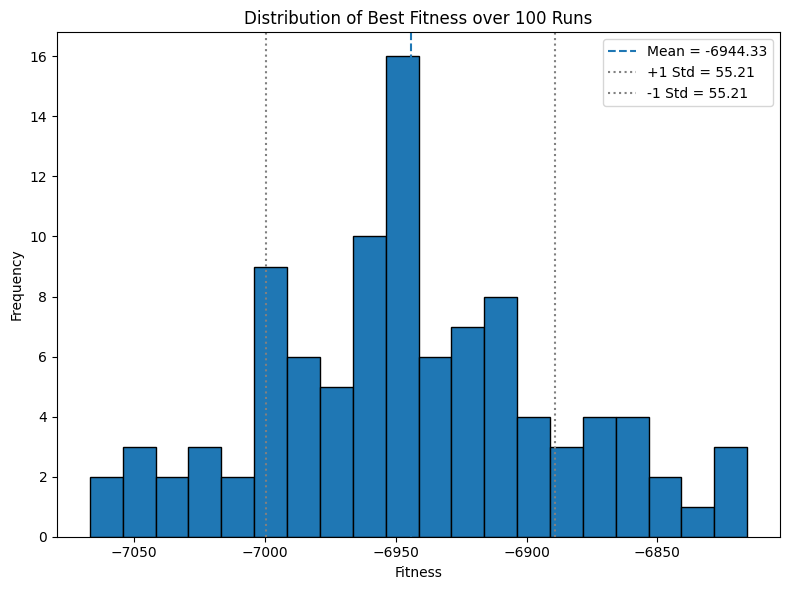

Mean fitness: -6944.3289
Std deviation of fitness: 55.2139


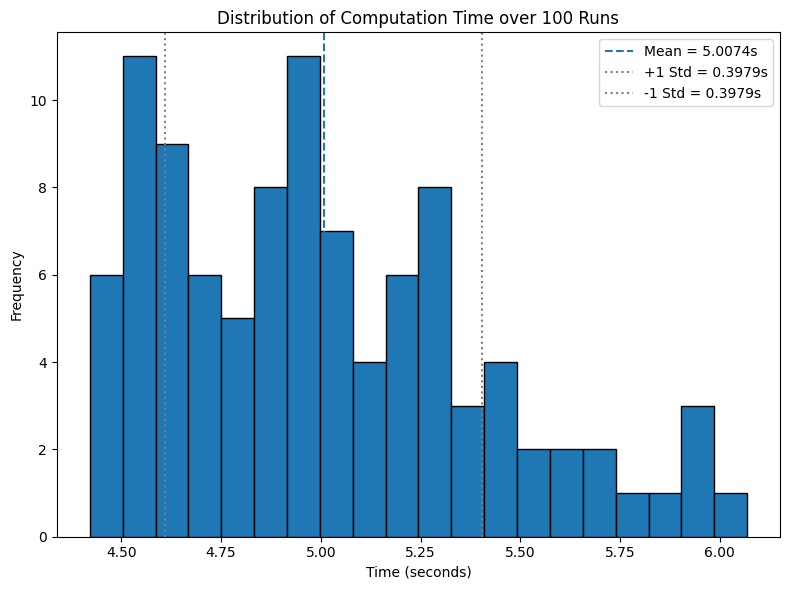

Mean computation time: 5.0074 seconds
Std deviation of time: 0.3979 seconds


(np.float64(-6944.32889252422),
 np.float64(55.21387963260811),
 np.float64(5.007373259067536),
 np.float64(0.3978864346284644))

In [16]:
plot_distributions_2(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)